In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from scipy import stats

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

import gc
from pathlib import Path


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['README.md', 'CAX_MortgageModeling_DataDictionary.pdf', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# set matplotlib ploting styles
sns.set()
sns.set_style('whitegrid')
sns.set_palette('muted')

In [178]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import catboost as cb

In [3]:
def show_all_pandas(df, nrow=None, ncol=None):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [85]:
DATA_DIR = Path('../input/')
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [86]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'

In [87]:
all_df = train_df.append(test_df)

In [88]:
all_df.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,train_test
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,FUNDED,train
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,FUNDED,train
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,FUNDED,train
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,FUNDED,train
4,CAX_Train_5,5,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,Refinance,Monthly,Single Detached,12,L7G,50-54,Male,147000,8,62,762,FUNDED,train


In [89]:
all_df['real_property_value'] = (all_df['MORTGAGE AMOUNT'] / all_df['LTV']) * 100

In [90]:
all_df['value_increase'] = ((all_df['PROPERTY VALUE'] - all_df['real_property_value']) > 0).astype(int)
all_df.loc[all_df['value_increase'] == 0, 'value_increase'] = -1
all_df.loc[all_df['real_property_value'] == all_df['PROPERTY VALUE'], 'value_increase'] = 0

In [91]:
all_df['perc_value_change'] = ((all_df['PROPERTY VALUE'] - all_df['real_property_value']) / all_df['real_property_value']) * 100

In [92]:
all_df['mort_sub_prop'] = all_df['MORTGAGE AMOUNT'] - all_df['PROPERTY VALUE']
all_df['mort_div_prop'] = (all_df['MORTGAGE AMOUNT'] / all_df['PROPERTY VALUE']) * 100

In [93]:
all_df.loc[all_df['PAYMENT FREQUENCY'] == 'Semi-Monthly', 'PAYMENT FREQUENCY'] = 'Bi-Weekly'

In [94]:
def emi_to_income_ratio(emi, pay_freq, income):
    if pay_freq == 'Monthly':
        return (emi * 12 / income) * 100
    elif pay_freq == 'Bi-Weekly':
        return (emi * 24 / income) * 100
    elif pay_freq == 'Bi-Weekly Accelerated':
        return (emi * 26 / income) * 100
    elif pay_freq == 'Weekly':
        return (emi * 48 / income) * 100
    else:
        return (emi * 52 / income) * 100

In [95]:
all_df['emi_div_income_annual'] = all_df.apply(lambda x: emi_to_income_ratio(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['INCOME']), axis=1)

In [96]:
def total_payment_tenure(emi, pay_freq, amort):
    if pay_freq == 'Monthly':
        return (emi * 12) * (amort / 12)
    elif pay_freq == 'Bi-Weekly':
        return (emi * 24) * (amort / 12)
    elif pay_freq == 'Bi-Weekly Accelerated':
        return (emi * 26) * (amort / 12)
    elif pay_freq == 'Weekly':
        return (emi * 48) * (amort / 12)
    else:
        return (emi * 52) * (amort / 12)

In [97]:
all_df['total_payment_tenure'] = all_df.apply(lambda x: total_payment_tenure(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['AMORTIZATION']), axis=1)

In [98]:
def total_payment_term(emi, pay_freq, term):
    if pay_freq == 'Monthly':
        return (emi * 12) * (term / 12)
    elif pay_freq == 'Bi-Weekly':
        return (emi * 24) * (term / 12)
    elif pay_freq == 'Bi-Weekly Accelerated':
        return (emi * 26) * (term / 12)
    elif pay_freq == 'Weekly':
        return (emi * 48) * (term / 12)
    else:
        return (emi * 52) * (term / 12)

In [99]:
all_df['total_payment_term'] = all_df.apply(lambda x: total_payment_term(x['MORTGAGE PAYMENT'], x['PAYMENT FREQUENCY'], x['TERM']), axis=1)

In [101]:
all_df['fsa_province'] = all_df['FSA'].str[0]
all_df['fsa_urban_rural'] = all_df['FSA'].str[0:2]

In [102]:
for col in ['fsa_province', 'fsa_urban_rural', 'FSA', 'AGE RANGE', 'INCOME TYPE', 'NAICS CODE']:
    gb = all_df.groupby([col])['CREDIT SCORE'].agg(['mean', 'std']).reset_index()
    gb.columns = [col, col + '_credit_score_mean', col + '_credit_score_std']
    all_df = all_df.merge(gb, on=col, how='left')

In [103]:
for col in ['FSA', 'fsa_urban_rural', 'PROPERTY TYPE', 'INCOME TYPE', 'NAICS CODE']:
    gb = all_df.groupby([col])['PROPERTY VALUE'].agg(['median', 'std']).reset_index()
    gb.columns = [col, col + '_property_value_median', col + '_property_value_std']
    all_df = all_df.merge(gb, on=col, how='left')

In [104]:
for col in ['FSA', 'fsa_urban_rural']:
    gb = all_df.groupby([col])['LTV'].agg(['mean', 'std']).reset_index()
    gb.columns = [col, col + '_ltv_mean', col + '_ltv_std']
    all_df = all_df.merge(gb, on=col, how='left')

In [105]:
for col in ['fsa_province', 'INCOME TYPE', 'NAICS CODE']:
    gb = all_df.groupby([col])['RATE'].agg(['mean', 'std']).reset_index()
    gb.columns = [col, col + '_rate_mean', col + '_rate_std']
    all_df = all_df.merge(gb, on=col, how='left')

In [106]:
for col in ['FSA', 'AGE RANGE', 'INCOME TYPE', 'NAICS CODE']:
    gb = all_df.groupby([col])['INCOME'].agg(['median', 'std']).reset_index()
    gb.columns = [col, col + '_income_median', col + '_income_std']
    all_df = all_df.merge(gb, on=col, how='left')

In [109]:
all_df.loc[all_df['RESULT'] == 'FUNDED', 'RESULT'] = 0
all_df.loc[all_df['RESULT'] == 'NOT FUNDED', 'RESULT'] = 1
all_df['RESULT'] = all_df['RESULT'].astype(float)

In [139]:
all_df['RESULT'].value_counts()

0.0    36023
1.0     9619
Name: RESULT, dtype: int64

In [110]:
show_all_pandas(all_df.head())

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT,train_test,real_property_value,value_increase,perc_value_change,mort_sub_prop,mort_div_prop,emi_div_income_annual,total_payment_tenure,total_payment_term,fsa_province,fsa_urban_rural,fsa_province_credit_score_mean,fsa_province_credit_score_std,fsa_urban_rural_credit_score_mean,fsa_urban_rural_credit_score_std,FSA_credit_score_mean,FSA_credit_score_std,AGE RANGE_credit_score_mean,AGE RANGE_credit_score_std,INCOME TYPE_credit_score_mean,INCOME TYPE_credit_score_std,NAICS CODE_credit_score_mean,NAICS CODE_credit_score_std,FSA_property_value_median,FSA_property_value_std,fsa_urban_rural_property_value_median,fsa_urban_rural_property_value_std,PROPERTY TYPE_property_value_median,PROPERTY TYPE_property_value_std,INCOME TYPE_property_value_median,INCOME TYPE_property_value_std,NAICS CODE_property_value_median,NAICS CODE_property_value_std,FSA_ltv_mean,FSA_ltv_std,fsa_urban_rural_ltv_mean,fsa_urban_rural_ltv_std,fsa_province_rate_mean,fsa_province_rate_std,INCOME TYPE_rate_mean,INCOME TYPE_rate_std,NAICS CODE_rate_mean,NAICS CODE_rate_std,FSA_income_median,FSA_income_std,AGE RANGE_income_median,AGE RANGE_income_std,INCOME TYPE_income_median,INCOME TYPE_income_std,NAICS CODE_income_median,NAICS CODE_income_std
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,Refinance,Monthly,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,0.0,train,1.600000e+06,-1,-43.750000,140000.0,115.555556,60.322222,1954440.0,65148.0,L,L4,659.786751,130.338404,671.560162,120.825950,695.444604,95.374928,673.626442,157.851915,680.753628,116.749266,671.624712,125.243519,723000,732723.566995,595000,512168.388467,550000,494347.868817,550000,521775.660125,500000,457259.065814,71.906076,12.130391,71.504154,11.787619,4.582809,0.636175,4.575162,0.635702,4.601361,0.641208,145000,177050.704940,80000,110823.218844,125000,143651.939727,105000,108228.008727
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,Refinance,Monthly,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,0.0,train,5.249697e+05,-1,-26.471949,4000.0,101.036269,33.523077,784440.0,26148.0,L,L9,659.786751,130.338404,656.457584,134.735556,670.160742,127.099576,655.138269,157.670558,646.537725,141.189342,647.019489,139.095510,510000,169379.970626,450000,264041.311221,550000,494347.868817,435000,281500.706050,440000,311621.197590,74.668896,9.072979,71.267638,11.228534,4.582809,0.636175,4.697963,0.634035,4.690499,0.633518,98000,68571.745077,69000,170515.811832,84000,54212.383734,85000,71368.742208
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,Purchase,Monthly,Single Detached,6,M1N,35-39,Female,87000,2,72,709,0.0,train,5.310000e+05,0,0.000000,-106200.0,80.000000,29.682759,774720.0,12912.0,M,M1,681.103002,127.205455,667.983537,127.850216,677.340741,126.758094,667.678700,124.341484,646.537725,141.189342,681.249383,129.373515,606000,339392.965727,530000,249124.407741,550000,494347.868817,435000,281500.706050,492000,411984.763965,72.312593,10.685861,72.039502,10.879823,4.575165,0.592111,4.697963,0.634035,4.531995,0.610512,105000,137665.507004,103000,107321.125448,84000,54212.383734,98000,110803.337674
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,Purchase,Monthly,Single Detached,12,M2M,45-49,Male,300000,8,54,761,0.0,train,1.280000e+06,-1,-6.250000,-240000.0,80.000000,21.640000,1947600.0,64920.0,M,M2,681.103002,127.205455,695.688763,118.895490,695.701422,120.357883,661.437426,128.573062,680.753628,116.749266,678.853978,118.526612,902000,629399.098925,640000,807502.520146,550000,494347.868817,550000,521775.660125,516000,433757.417038,72.150256,11.319546,72.090536,10.448661,4.575165,0.592111,4.575162,0.635702,4.575031,0.620774,180000,126104.808587,101000,114934.033339,125000,143651.939727,110000,93869.033675
4,CAX_Train_5,5,

In [111]:
all_df.shape

(60856, 73)

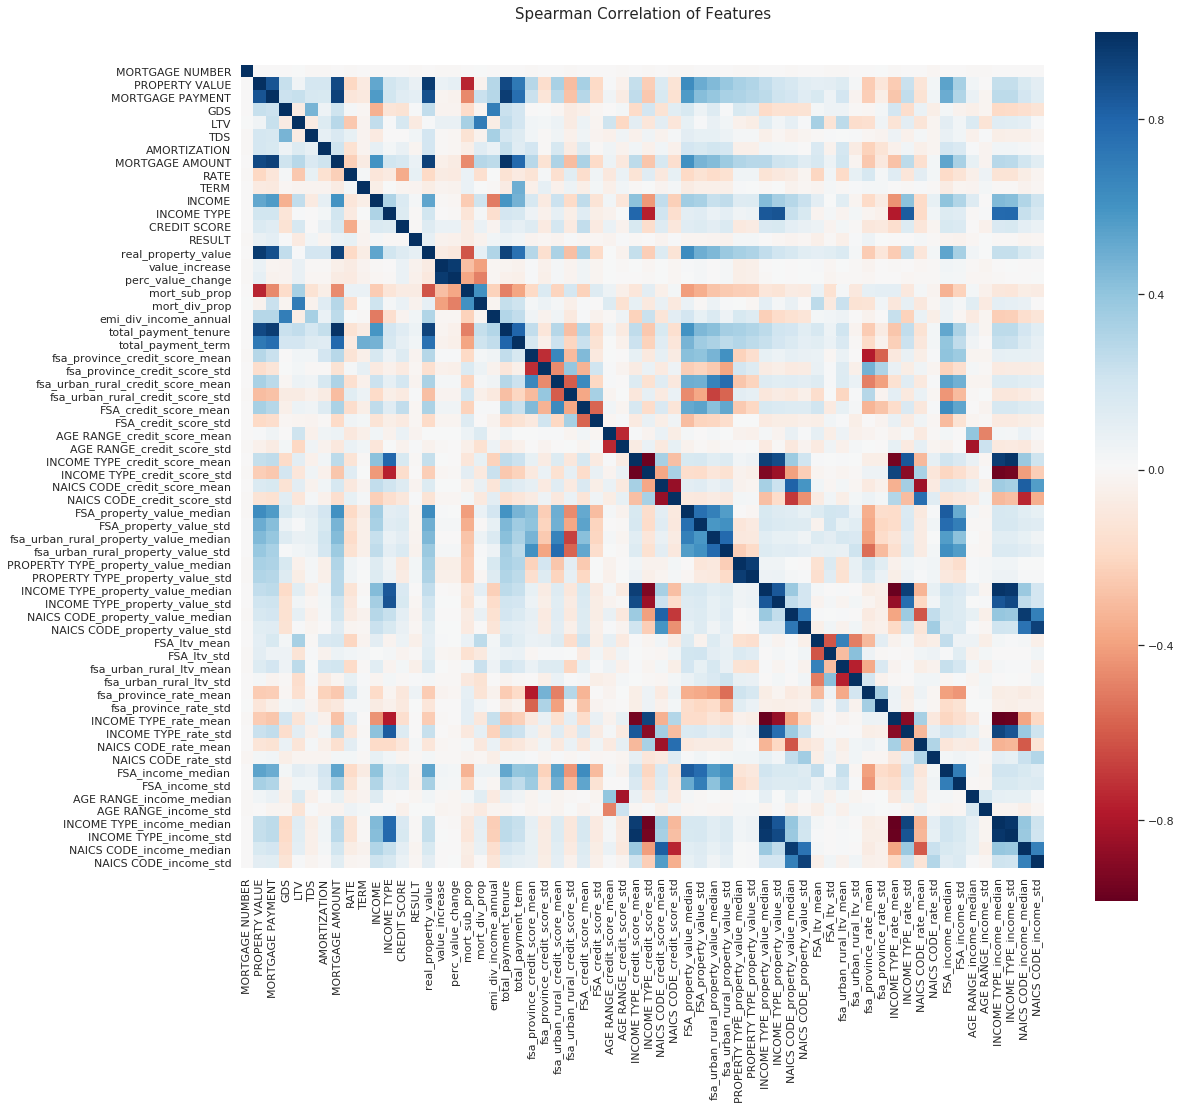

In [112]:
cor = all_df.corr(method='spearman') 
colormap = plt.cm.RdBu
plt.figure(figsize=(18,16))
plt.title('Spearman Correlation of Features', y=1.05, size=15)
sns.heatmap(cor, square=True, cmap=colormap, linecolor='white')
plt.show()

In [145]:
# missing values info function
def missing_info(df):    
    x = df.isnull().sum()[(df.isnull().sum() > 0)]
    d = pd.DataFrame(x, columns=['missing values'])
    d['% of missing values'] = np.round((x/df.shape[0]) * 100, decimals=2)
    return d

In [146]:
missing_info(all_df)

,missing values,% of missing values
RESULT,15214,25.00
fsa_province_credit_score_std,1,0.00
fsa_urban_rural_credit_score_std,9,0.01
FSA_credit_score_std,104,0.17
FSA_property_value_std,104,0.17
fsa_urban_rural_property_value_std,9,0.01
FSA_ltv_std,104,0.17
fsa_urban_rural_ltv_std,9,0.01
fsa_province_rate_std,1,0.00
FSA_income_std,104,0.17


In [118]:
features = [col for col in all_df.columns if col not in ['Unique_ID', 'MORTGAGE NUMBER', 'RESULT', 'train_test']]
target_col = 'RESULT'
cat_cols = ['MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'AGE RANGE', 'GENDER', 'INCOME TYPE', 'NAICS CODE', 'FSA', 'fsa_province', 'fsa_urban_rural']

In [149]:
cat_inds = []
for i, f in enumerate(features):
    if f in cat_cols:
        cat_inds.append(i)
        
print(cat_inds)

[8, 9, 10, 12, 13, 14, 16, 17, 27, 28]


In [119]:
len(features)

69

In [120]:
all_df[cat_cols] = all_df[cat_cols].astype('category')

In [122]:
train_df = all_df[all_df['train_test'] == 'train'].copy()
test_df = all_df[all_df['train_test'] == 'test'].copy()

In [123]:
train_df[target_col] = train_df[target_col].astype(int)

In [161]:
def cv_metric(actual, predicted):
    f1_scores = []
    thresholds = []
    for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
        pred_thres = (predicted > thresh).astype(int) 
        f1_scores.append(f1_score(actual, pred_thres, average='macro'))
        thresholds.append(thresh)
    
    max_ind = np.array(f1_scores).argmax()
    max_f1 = np.array(f1_scores)[max_ind]
    max_thresh = np.array(thresholds)[max_ind]
    return max_f1, max_thresh

In [179]:
def run_cv_model(train, features, target, model_fn, params={}, n_splits=5, test=None, label='model', cv_verbose = False, model_verbose=False):
    kf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    fold_splits = kf.split(train[features], train[target])
    cv_scores = []
    pred_full_test = np.zeros((test.shape[0], n_splits))
    pred_train = np.zeros((train.shape[0], 2))
    feature_importance_df = pd.DataFrame()
    target = train[target]
    train = train[features]
    i = 1
    for dev_index, val_index in fold_splits:
        if cv_verbose:
            print('Started ' + label + ' fold ' + str(i) + '/'+str(n_splits))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances = model_fn(dev_X, dev_y, val_X, val_y, test[features], params2, model_verbose)
        pred_full_test[:, i-1] = pred_test_y.flatten()
        pred_train[val_index,  0] = pred_val_y.flatten().tolist()
        pred_train[val_index, 1] = i
        
        cv_score, thresh = cv_metric(val_y, pred_val_y)
        
        cv_scores.append(cv_score)
        
        if cv_verbose:
            print(label + ' cv score {}: (F1 macro) {} at threshold {}'.format(i, cv_score, thresh))
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = train.columns.values
        fold_importance_df['importance'] = importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
            
        i += 1
    
    if cv_verbose:
        print("\n\n CV - Report\n")
        print('{} cv (ROC-AUC) scores : {}'.format(label, cv_scores))
        print('{} cv mean (ROC-AUC) score : {}'.format(label, np.mean(cv_scores)))
        print('{} cv std (ROC-AUC) score : {}'.format(label, np.std(cv_scores)))
        
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores,
               'importance': feature_importance_df}
    return results

In [180]:
def runLGB(train_X, train_y, test_X, test_y, test_X2, params, model_verbose):
    if model_verbose:
        print('Prep LGBM Classifier')
    d_train = lgb.Dataset(train_X, label=train_y)
    d_valid = lgb.Dataset(test_X, label=test_y)
    watchlist = [d_train, d_valid]
    if model_verbose:
        print('Train LGBM Classifier')
    num_rounds = params.pop('num_rounds')
    verbose_eval = params.pop('verbose_eval')
    early_stop = None
    if params.get('early_stop'):
        early_stop = params.pop('early_stop')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    if model_verbose:
        print('Predict validation set')
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    # cv_score = cv_metric(test_y, pred_test_y)
    if model_verbose:
        print('Predict actual test set')
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
        pred_test_y2 = pred_test_y2.reshape(-1, 1)
    else:
        pred_test_y2 = 0
    pred_test_y = pred_test_y.reshape(-1, 1)
    
    return pred_test_y, pred_test_y2, model.feature_importance()

In [186]:
lgb_params = {}
lgb_params["objective"] = "binary"
lgb_params['metric'] = 'auc'
lgb_params["max_depth"] = 10
lgb_params["num_leaves"] = 150
lgb_params["min_data_in_leaf"] = 200
lgb_params["learning_rate"] = 0.01
lgb_params["bagging_fraction"] = 0.8
lgb_params["feature_fraction"] = 0.35
lgb_params["feature_fraction_seed"] = 0
lgb_params["bagging_freq"] = 1
lgb_params["bagging_seed"] = 0
lgb_params["lambda_l2"] = 8
lgb_params["lambda_l1"] = 5
lgb_params["verbosity"] = -1
lgb_params["num_rounds"] = 10000
lgb_params["verbose_eval"] = 500
lgb_params["early_stop"] = 500
lgb_params['scale_pos_weight'] = 3

results_lgb = run_cv_model(train_df, features, target_col, runLGB, lgb_params, n_splits=5, test=test_df, label='LGBM', cv_verbose=True, model_verbose=True)

Started LGBM fold 1/5
Prep LGBM Classifier
Train LGBM Classifier


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.845504	valid_1's auc: 0.747959
[1000]	training's auc: 0.887715	valid_1's auc: 0.752468
[1500]	training's auc: 0.919189	valid_1's auc: 0.753673
[2000]	training's auc: 0.94221	valid_1's auc: 0.75402
Early stopping, best iteration is:
[1802]	training's auc: 0.934217	valid_1's auc: 0.754039
Predict validation set
Predict actual test set
LGBM cv score 1: (F1 macro) 0.6565158928547352 at threshold 0.5
Started LGBM fold 2/5
Prep LGBM Classifier
Train LGBM Classifier


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.847953	valid_1's auc: 0.739021
[1000]	training's auc: 0.889046	valid_1's auc: 0.741581
[1500]	training's auc: 0.919753	valid_1's auc: 0.741764
Early stopping, best iteration is:
[1256]	training's auc: 0.906064	valid_1's auc: 0.742239
Predict validation set
Predict actual test set
LGBM cv score 2: (F1 macro) 0.6507016078841588 at threshold 0.5
Started LGBM fold 3/5
Prep LGBM Classifier
Train LGBM Classifier


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.846587	valid_1's auc: 0.737693
[1000]	training's auc: 0.888359	valid_1's auc: 0.742598
[1500]	training's auc: 0.919634	valid_1's auc: 0.743645
[2000]	training's auc: 0.942772	valid_1's auc: 0.743486
Early stopping, best iteration is:
[1886]	training's auc: 0.938266	valid_1's auc: 0.743901
Predict validation set
Predict actual test set
LGBM cv score 3: (F1 macro) 0.6519005923069312 at threshold 0.5
Started LGBM fold 4/5
Prep LGBM Classifier
Train LGBM Classifier


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.845948	valid_1's auc: 0.729534
[1000]	training's auc: 0.888258	valid_1's auc: 0.734928
[1500]	training's auc: 0.919317	valid_1's auc: 0.736576
[2000]	training's auc: 0.942697	valid_1's auc: 0.736443
Early stopping, best iteration is:
[1729]	training's auc: 0.931095	valid_1's auc: 0.737
Predict validation set
Predict actual test set
LGBM cv score 4: (F1 macro) 0.6482968628226139 at threshold 0.5
Started LGBM fold 5/5
Prep LGBM Classifier
Train LGBM Classifier


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.846507	valid_1's auc: 0.737662
[1000]	training's auc: 0.888353	valid_1's auc: 0.74198
[1500]	training's auc: 0.91951	valid_1's auc: 0.743542
[2000]	training's auc: 0.942407	valid_1's auc: 0.743311
Early stopping, best iteration is:
[1656]	training's auc: 0.927597	valid_1's auc: 0.743625
Predict validation set
Predict actual test set
LGBM cv score 5: (F1 macro) 0.6488063528926884 at threshold 0.5


 CV - Report

LGBM cv (ROC-AUC) scores : [0.6565158928547352, 0.6507016078841588, 0.6519005923069312, 0.6482968628226139, 0.6488063528926884]
LGBM cv mean (ROC-AUC) score : 0.6512442617522255
LGBM cv std (ROC-AUC) score : 0.002937546512183289


In [187]:
imports_lgb = results_lgb['importance'].groupby('feature')['importance'].describe().reset_index()
show_all_pandas(imports_lgb.sort_values('mean', ascending=False).reset_index(drop=True))

,feature,count,mean,std,min,25%,50%,75%,max
0,FSA,5.0,5960.2,951.030862,4393.0,5901.0,6122.0,6520.0,6865.0
1,fsa_urban_rural,5.0,5600.8,811.418326,4233.0,5634.0,5763.0,6032.0,6342.0
2,NAICS CODE,5.0,4471.2,723.365537,3280.0,4388.0,4705.0,4803.0,5180.0
3,AGE RANGE,5.0,4203.2,792.874013,2860.0,4280.0,4344.0,4606.0,4926.0
4,perc_value_change,5.0,3854.4,348.822018,3309.0,3737.0,3947.0,4093.0,4186.0
5,TDS,5.0,3791.2,653.996713,2670.0,3916.0,3953.0,4030.0,4387.0
6,CREDIT SCORE,5.0,3477.0,634.470251,2430.0,3504.0,3547.0,3783.0,4121.0
7,GDS,5.0,3238.6,625.451277,2240.0,3151.0,3317.0,3591.0,3894.0
8,real_property_value,5.0,3054.0,408.230327,2389.0,2980.0,3217.0,3227.0,3457.0
9,mort_sub_prop,5.0,2950.4,461.730766,2178.0,2966.0,3033.0,3183.0,3392.0


In [196]:
pd.Series((results_lgb['test'] > 0.5).astype(int).sum(axis=1) > 2).value_counts()

False    11478
True      3736
dtype: int64

In [197]:
from IPython.display import FileLink

In [200]:
sub_df = pd.DataFrame(columns=['Unique_ID', 'Result_Predicted'])
ans = (results_lgb['test'] > 0.5).astype(int).sum(axis=1) > 2
sub_df['Unique_ID'] = test_df['Unique_ID']
sub_df['Result_Predicted'] = ans
sub_df.loc[sub_df['Result_Predicted'] == True, 'Result_Predicted'] = 'NOT FUNDED'
sub_df.loc[sub_df['Result_Predicted'] == False, 'Result_Predicted'] = 'FUNDED'

In [201]:
sub_df.head()

,Unique_ID,Result_Predicted
45642,CAX_Test_1,NOT FUNDED
45643,CAX_Test_2,FUNDED
45644,CAX_Test_3,FUNDED
45645,CAX_Test_4,FUNDED
45646,CAX_Test_5,FUNDED


In [202]:
sub_df.to_csv('sub.csv', index=False)
FileLink('sub.csv')

/kaggle/working/sub.csv

In [204]:
# CV score ~ 0.65
# Leader board score ~ 0.65